## ML for Asset Management - Marcos Lopez Prado 

**Date:** 2025-05-20 

Working through the content in the textbook. Beach day so copying over earlier work.

### Section 2 - Denoising & Detoning

The goal of this section is to explain a procedure for reducing the noise and enhancing the signal included in an empirical covariance matrix. Throughout this Element, we assume that empirical covariance and correlation matrices have been subjected to this procedure.

### 2.1- The Marcenko Pastur PDF

This function mpPDF implements the Marčenko–Pastur (MP) probability density function which is used to describe the distribution of eigenvalues of large random covariance matrices.

In [2]:
# 2.1 THE MARCENKO–PASTUR PDF
import numpy as np
import pandas as pd

#--------------------------------------------------- 
def mpPDF(var, q, pts):
    # Marcenko-Pastur PDF
    # q = T / N
    eMin = var * (1 - (1. / q) ** 0.5) ** 2
    eMax = var * (1 + (1. / q) ** 0.5) ** 2
    eVal = np.linspace(eMin, eMax, pts)
    pdf = q / (2 * np.pi * var * eVal) * ((eMax - eVal) * (eVal - eMin)) ** 0.5
    pdf = pd.Series(pdf, index=eVal)
    return pdf


### 2.2 Testing -
 
This block of code is testing the Marčenko–Pastur (MP) theorem using randomly simulated data. The goal is to compare the empirical distribution of eigenvalues of a random correlation matrix with the theoretical MP distribution.

In [3]:
# 2.2 TESTING THE MARCENKO–PASTUR THEOREM 

from sklearn.neighbors import KernelDensity

#---------------------------------------------------
def getPCA(matrix):
    # Get eVal, eVec from a Hermitian matrix
    eVal, eVec = np.linalg.eigh(matrix)
    indices = eVal.argsort()[::-1]  # arguments for sorting eVal desc
    eVal, eVec = eVal[indices], eVec[:, indices]
    eVal = np.diagflat(eVal)
    return eVal, eVec

#---------------------------------------------------
def fitKDE(obs, bWidth=.25, kernel='gaussian', x=None):
    # Fit kernel to a series of obs, and derive the prob of obs
    # x is the array of values on which the fit KDE will be evaluated
    if len(obs.shape) == 1:
        obs = obs.reshape(-1, 1)
    kde = KernelDensity(kernel=kernel, bandwidth=bWidth).fit(obs)
    if x is None:
        x = np.unique(obs).reshape(-1, 1)
    if len(x.shape) == 1:
        x = x.reshape(-1, 1)
    logProb = kde.score_samples(x)  # log(density)
    values = np.exp(logProb)
    index = x.ravel().astype(float)
    pdf = pd.Series(values, index)
    return pdf

#---------------------------------------------------
x = np.random.normal(size=(10000, 1000))
eVal0, eVec0 = getPCA(np.corrcoef(x, rowvar=0))
pdf0 = mpPDF(1., q=x.shape[0] / float(x.shape[1]), pts=1000)
print("eVal0 shape:", eVal0.shape)
print("np.diag(eVal0).shape:", np.diag(eVal0).shape)
pdf1 = fitKDE(np.diag(eVal0), bWidth=.01)  # empirical pdf


eVal0 shape: (1000, 1000)
np.diag(eVal0).shape: (1000,)


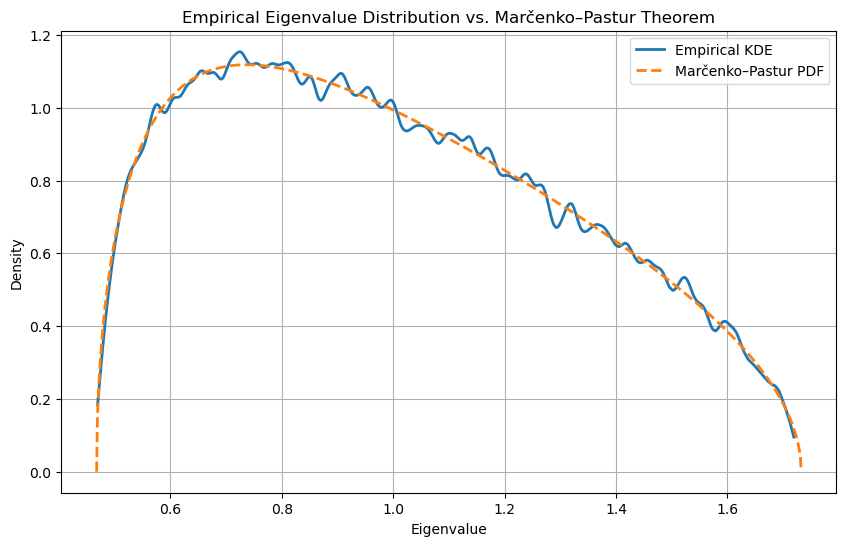

In [4]:
# Plotting:

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# Plot empirical KDE of eigenvalues
plt.plot(pdf1.index, pdf1.values, label='Empirical KDE', lw=2)

# Plot theoretical Marčenko–Pastur PDF
plt.plot(pdf0.index, pdf0.values, label='Marčenko–Pastur PDF', lw=2, linestyle='--')

plt.title('Empirical Eigenvalue Distribution vs. Marčenko–Pastur Theorem')
plt.xlabel('Eigenvalue')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


### 2.3 

This code adds structured signal to an otherwise random covariance matrix to simulate a more realistic financial dataset — one that contains both noise and true factors. This sets the stage for detecting meaningful components using random matrix theory.

In [5]:
# 2.3 ADD SIGNAL TO A RANDOM COVARIANCE MATRIX
def getRndCov(nCols, nFacts):
    w = np.random.normal(size=(nCols, nFacts))
    cov = np.dot(w, w.T)  # random cov matrix, however not full rank
    cov += np.diag(np.random.uniform(size=nCols))  # full rank
    return cov

#---------------------------------------------------
def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std, std)
    corr[corr < -1], corr[corr > 1] = -1, 1  # numerical error
    return corr

#---------------------------------------------------
alpha, nCols, nFact, q = 0.995, 1000, 100, 10
cov = np.cov(np.random.normal(size=(nCols * q, nCols)), rowvar=0)
cov = alpha * cov + (1 - alpha) * getRndCov(nCols, nFact)  # noise + signal
corr0 = cov2corr(cov)
eVal0, eVec0 = getPCA(corr0)


### Fitting the MP PDF

The goal is to estimate the upper bound of the noise eigenvalues, and infer the number of factors (i.e., how much signal lies beyond noise).

In [6]:
#2.4 FITTING THE MARCENKO–PASTUR PDF 
from scipy.optimize import minimize

#---------------------------------------------------
def errPDFs(var, eVal, q, bWidth, pts=1000):
    # Fit error
    pdf0 = mpPDF(var, q, pts)  # theoretical pdf
    pdf1 = fitKDE(eVal, bWidth, x=pdf0.index.values)  # empirical pdf
    sse = np.sum((pdf1 - pdf0) ** 2)
    return sse

#---------------------------------------------------
def findMaxEval(eVal, q, bWidth):
    # Use a lambda that extracts the float from the array
    out = minimize(lambda var: errPDFs(var[0], eVal, q, bWidth),
                   x0=[0.5], bounds=[(1E-5, 1 - 1E-5)])
    if out['success']:
        var = out['x'][0]
    else:
        var = 1.0
    eMax = var * (1 + (1. / q) ** 0.5) ** 2
    return eMax, var
#---------------------------------------------------

eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth=0.01)
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)

print("eMax0:", eMax0)
print("var0:", var0)
print("Estimated number of signal factors:", nFacts0)


eMax0: 1.1730445894781416
var0: 0.6770993931954725
Estimated number of signal factors: 100


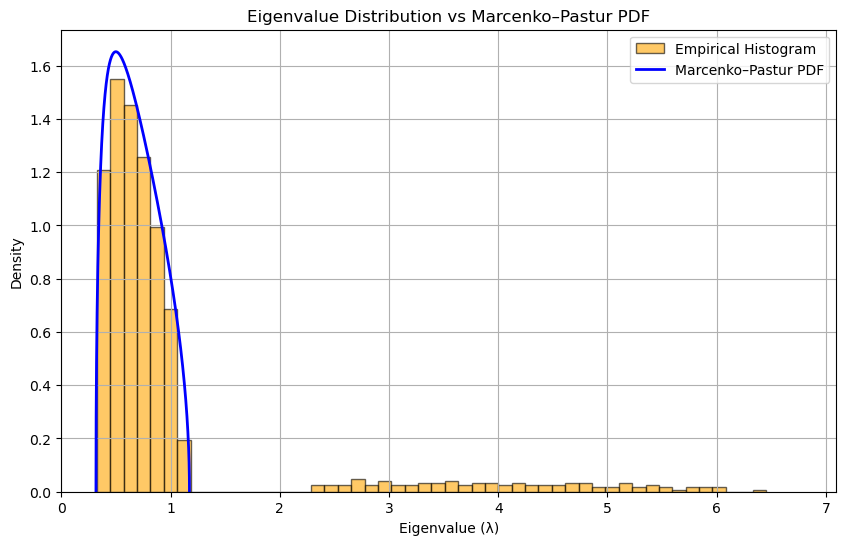

In [7]:

eigenvalues = np.diag(eVal0)

# Marcenko–Pastur parameters
var = 0.6768
q = 10
pdf = mpPDF(var, q, pts=1000)

# Plot both on same figure
plt.figure(figsize=(10, 6))

# Histogram of empirical eigenvalues
plt.hist(eigenvalues, bins=50, density=True, color='orange', edgecolor='black', alpha=0.6, label='Empirical Histogram')

# Marcenko–Pastur theoretical PDF
pdf.plot(label='Marcenko–Pastur PDF', color='blue', lw=2)

# Plot formatting
plt.title("Eigenvalue Distribution vs Marcenko–Pastur PDF")
plt.xlabel("Eigenvalue (λ)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.xlim(0, max(max(eigenvalues), pdf.index.max()) * 1.1)
plt.show()


### 2.5 Denoising using MP PDF

- In finance, empirical covariance matrices are often noisy and unstable, especially with high-dimensional data.

- Shrinkage is a popular fix: it blends your matrix with the identity matrix (or something close to it). However, it shrinks noise and signal alike

- This reduces the condition number (the ratio of the largest to smallest eigenvalue), which stabilizes downstream computations like portfolio optimization.

Step 1: Eigen-Decompose the Correlation Matrix

Step 2: Find the noise threshold lambda+

Step 3: Replace noise eigenvalues with a constant average

Step 4: Reconstruct the Matrix using the modified eigenvalues

Step 5: Rescale so the diagonal is one.


In [8]:
def denoisedCorr(eVal, eVec, nFacts):
    # Step 1: Copy eigenvalues
    eVal_ = np.diag(eVal).copy()

    # Step 2: Average the noise eigenvalues and replace them
    eVal_[nFacts:] = eVal_[nFacts:].sum() / float(eVal_.shape[0] - nFacts)

    # Step 3: Reconstruct the matrix
    corr1 = np.dot(eVec, np.diag(eVal_)).dot(eVec.T)

    # Step 4: Rescale to make diagonal = 1 (turn into correlation matrix)
    corr1 = cov2corr(corr1)

    return corr1

corr1 = denoisedCorr(eVal0, eVec0, nFacts0) #the cleaned, denoised correlation matrix
eVal1, eVec1 = getPCA(corr1) #New eigenvalues and eigenvectors


### 2.6 Denoising by targeted shrinkage



In [9]:
def denoisedCorr2(eVal, eVec, nFacts, alpha=0):
    # Remove noise from corr through targeted shrinkage

    # Signal eigenvalues and eigenvectors
    eValL, eVecL = eVal[:nFacts, :nFacts], eVec[:, :nFacts]

    # Noise eigenvalues and eigenvectors
    eValR, eVecR = eVal[nFacts:, nFacts:], eVec[:, nFacts:]

    # Reconstruct signal and noise components
    corr0 = np.dot(eVecL, eValL).dot(eVecL.T)
    corr1 = np.dot(eVecR, eValR).dot(eVecR.T)

    # Apply targeted shrinkage to noise
    corr2 = corr0 + alpha * corr1 + (1 - alpha) * np.diag(np.diag(corr1))
    
    return corr2

#---------------------------------------------------

# Apply the denoising method
corr1 = denoisedCorr2(eVal0, eVec0, nFacts0, alpha=0.5)

# Recompute PCA on denoised matrix
eVal1, eVec1 = getPCA(corr1)


### 2.6 Detoning

- Financial correlation matrices usually incorporate a market component. The market component is characterized by the first eigenvector
- Accordingly, a market component affects every item of the covariance matrix. In the context of clustering applications, it is useful to remove the market component
- The reason is, it is more difficult to cluster a correlation matrix with a strong market component, because the algorithm will struggle to find dissimilarities across clusters.
- By removing the market component, we allow a greater portion of the correlation to be explained by components that affect specific subsets of the securities. It is similar to removing a loud tone that prevents us from hearing other sounds

### 2.7 Experimental Results:

Minimum Varience Portfolio:

- In this section, we compute the errors associated with estimating a minimum variance portfolio with and without denoising.

- Forms a vector of means and a covariance matrix out of ten blocks of size fifty each, where off-diagonal elements within each block have a correlation of 0.5.

- This covariance matrix is a stylized representation of a true (nonempirical) detoned correlation matrix of the S&P 500, where each block is associated with an economic sector.

In [10]:
from scipy.linalg import block_diag
from sklearn.covariance import LedoitWolf

#---------------------------------------------------
# Convert correlation matrix to covariance matrix
def corr2cov(corr, std):
    return np.outer(std, std) * corr

# Create a block-diagonal correlation matrix
def formBlockMatrix(nBlocks, bSize, bCorr):
    block = np.ones((bSize, bSize)) * bCorr
    np.fill_diagonal(block, 1)  # set diagonal to 1
    corr = block_diag(*([block] * nBlocks))
    return corr

#---------------------------------------------------
# Create the true covariance matrix and mean vector
def formTrueMatrix(nBlocks, bSize, bCorr):
    corr0 = formBlockMatrix(nBlocks, bSize, bCorr)
    corr0 = pd.DataFrame(corr0)

    # Shuffle rows/columns to avoid block structure bias
    cols = corr0.columns.tolist()
    np.random.shuffle(cols)
    corr0 = corr0[cols].loc[cols].copy(deep=True)

    # Generate random volatilities (std dev)
    std0 = np.random.uniform(0.05, 0.2, corr0.shape[0])

    # Convert to covariance matrix
    cov0 = corr2cov(corr0, std0)

    # Generate random mean vector
    mu0 = np.random.normal(std0, std0, cov0.shape[0]).reshape(-1, 1)

    return mu0, cov0

#---------------------------------------------------
# Parameters and random seed
nBlocks, bSize, bCorr = 10, 50, 0.5
np.random.seed(0)

# Generate true mean and covariance matrix
mu0, cov0 = formTrueMatrix(nBlocks, bSize, bCorr)


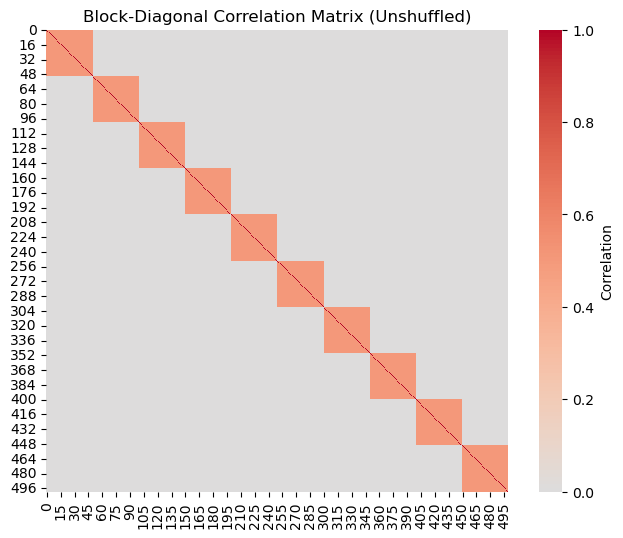

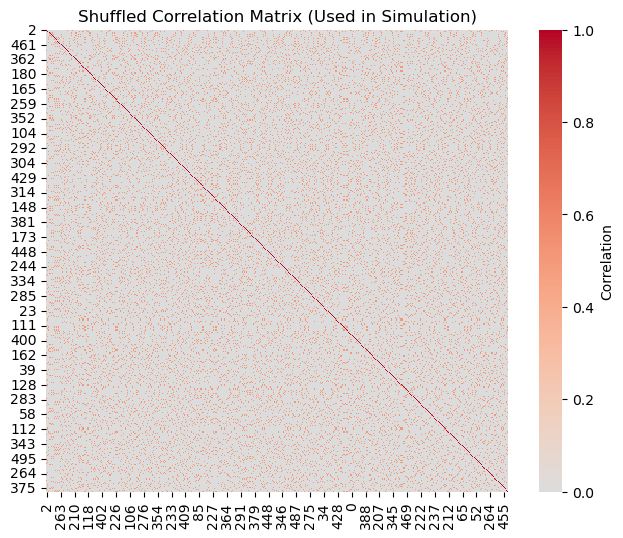

In [11]:
#Visualizing:

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Unshuffled correlation matrix (clear block structure)
corr_block = formBlockMatrix(nBlocks, bSize, bCorr)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_block, cmap='coolwarm', center=0, square=True, cbar_kws={'label': 'Correlation'})
plt.title("Block-Diagonal Correlation Matrix (Unshuffled)")
plt.show()

# 2. Shuffled correlation matrix from formTrueMatrix
mu0, cov0 = formTrueMatrix(nBlocks, bSize, bCorr)
corr_shuffled = cov0 / np.outer(np.sqrt(np.diag(cov0)), np.sqrt(np.diag(cov0)))

plt.figure(figsize=(8, 6))
sns.heatmap(corr_shuffled, cmap='coolwarm', center=0, square=True, cbar_kws={'label': 'Correlation'})
plt.title("Shuffled Correlation Matrix (Used in Simulation)")
plt.show()



### 2.8 - Generating the Empirical Covariance Matrix:

- Uses the true (nonempirical) covariance matrix to draw a random matrix X of size TxN , and it derives the associated empirical covariance matrix and vector of means. 

In [12]:
def simCovMu(mu0, cov0, nObs, shrink=False):
    # Simulate multivariate returns and estimate mean/covariance
    x = np.random.multivariate_normal(mu0.flatten(), cov0, size=nObs)
    
    # Sample mean vector
    mu1 = x.mean(axis=0).reshape(-1, 1)
    
    # Sample covariance matrix
    if shrink:
        cov1 = LedoitWolf().fit(x).covariance_
    else:
        cov1 = np.cov(x, rowvar=False)
    
    return mu1, cov1

### 2.9 - Application using Denoising

In [13]:
# Denoise through the constant residual eigenvalue method.

def deNoiseCov(cov0, q, bWidth):
    # Step 1: Convert covariance matrix to correlation matrix
    corr0 = cov2corr(cov0)

    # Step 2: Perform PCA
    eVal0, eVec0 = getPCA(corr0)

    # Step 3: Find Marcenko–Pastur threshold and number of factors
    eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth)
    nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)

    # Step 4: Denoise the correlation matrix
    corr1 = denoisedCorr(eVal0, eVec0, nFacts0)

    # Step 5: Rescale denoised correlation back to covariance
    cov1 = corr2cov(corr1, np.sqrt(np.diag(cov0)))

    return cov1


In [14]:
from tqdm import tqdm

#---------------------------------------------------
def optPort(cov, mu=None):
    inv = np.linalg.inv(cov)
    ones = np.ones(shape=(inv.shape[0], 1))
    if mu is None:
        mu = ones
    w = np.dot(inv, mu)
    w /= np.dot(ones.T, w)
    return w

#---------------------------------------------------
# Simulation parameters
nObs = 1000
nTrials = 1000
bWidth = 0.01
shrink = False
minVarPortf = True

# Create results DataFrames
w1 = pd.DataFrame(columns=range(cov0.shape[0]), index=range(nTrials), dtype=float)
w1_d = w1.copy(deep=True)

np.random.seed(0)

# Run portfolio optimization trials with progress bar
for i in tqdm(range(nTrials), desc="Running Monte Carlo trials"):
    mu1, cov1 = simCovMu(mu0, cov0, nObs, shrink=shrink)

    if minVarPortf:
        mu1 = None  # Min variance portfolio doesn't use mu

    cov1_d = deNoiseCov(cov1, q=nObs / float(cov1.shape[1]), bWidth=bWidth)

    w1.loc[i] = optPort(cov1, mu1).flatten()
    w1_d.loc[i] = optPort(cov1_d, mu1).flatten()


Running Monte Carlo trials: 100%|██████████| 1000/1000 [09:05<00:00,  1.83it/s] 


In [15]:
# Comparing with true minimum variance portfolio:

# Step 1: True optimal weights from the true covariance matrix
w0 = optPort(cov0, None if minVarPortf else mu0)

# Step 2: Repeat w0 to match the shape of simulation output (DataFrame w1)
w0 = np.repeat(w0.T, w1.shape[0], axis=0)

# Step 3: Compute RMSE (non-denoised portfolio weights)
rmsd = np.mean((w1.values - w0)**2)**0.5  # or np.sqrt(np.mean(...))

# Step 4: Compute RMSE (denoised portfolio weights)
rmsd_d = np.mean((w1_d.values - w0)**2)**0.5

# Step 5: Print results
print("RMSE (not denoised):", rmsd)
print("RMSE (denoised):    ", rmsd_d)


RMSE (not denoised): 0.005065598652738478
RMSE (denoised):     0.0011976371270380854


### Chapter 2 Conclusions:

In finance, empirical covariance matrices are often ill-conditioned due to limited data relative to the number of assets. This leads to unstable matrix inversion, which inflates estimation error and causes misallocation and excessive rebalancing.

The Marčenko–Pastur theorem provides a principled way to distinguish between signal and noise in the eigenvalue spectrum of a covariance (or correlation) matrix. By fitting this distribution, we can denoise the matrix without discarding valuable information.

Compared to:

- Variance-thresholding PCA (which ignores the structure of noise), and

- Shrinkage estimators (which dilute signal alongside noise),

the MP-based denoising approach is more targeted and effective.

Denoising improves the matrix’s condition number by lifting small (noisy) eigenvalues. Additional improvements can be made by detoning, i.e., removing dominant components like market-wide risk, which reveals subtler structures such as sector or industry exposure.

While we've applied denoising to portfolio optimization, it’s broadly useful:

- Reducing variance in regression models (e.g., when inverting $X^T X$)

- Improving the robustness of statistical tests

- Enhancing factor-based covariance matrices

Bottom line: Denoising is essential when working with empirical covariance matrices in finance. It boosts numerical stability and uncovers true structure without unnecessary signal loss.